### Imports

In [101]:
import numpy as np
from numpy.linalg import norm, qr, inv, svd, solve
from time import time
from matplotlib import pyplot as plt

### Gram-Schmidt algorithm

In [102]:
def get_random_matrix(size):
    """ Gets random square matrix 
    
    :arg
        size: matrix has size (`size` x `size`)
    
    :returns
        random square matrix
    """
    a = np.random.rand(size, size)
    
    return a;

def qr_decomposition(a):
    """ Returns matrices Q and R of QR decomposition of square matrix `a` 
    
    :arg
        a: matrix which will be decomposed
        
    :returns
        orthogonal matrix `q` and upper triangular matrix `r` such that `a` = `q` @ `r`
    """
    q = np.zeros(a.shape, dtype=np.float64)
    r = np.zeros(a.shape, dtype=np.float64)
    
    for i in range(a.shape[1]):
        q[:, i] = a[:, i]
        
        for j in range(i):
            dot_product = np.dot(a[:, i], q[:, j])
            r[j, i] = dot_product
            q[:, i] -=  dot_product * q[:, j]
            
        q[:, i] /= norm(q[:, i])
        r[i, i] = np.dot(a[:, i], q[:, i])
          
    return q, r

def compare_with_numpy(a, epsilon):
    """ Checks if function `qr_decomposition` returns the same matrices 
    as numpy's funtion `qr` and compares times of executions
    
    :arg
        a:       matrix which will be decomposed by both functions
        epsilon: difference between results can be no bigger than epsilon to
            qualify `qr_decomposition` function as correct
    """
    start_time = time()
    my_q, my_r = qr_decomposition(a)
    my_function_time = time() - start_time
    
    start_time = time()
    q, r = qr(a)
    numpy_time = time() - start_time
    
    if np.all(abs(my_q) - abs(q) < epsilon) and np.all(abs(my_r) - abs(r) < epsilon):
        print(f"Decomposition for matrix of size {a.shape[0]}x{a.shape[1]} is correct with accuracy {epsilon}")
    else:
        print("Decomposition is incorrect")
        
    print(f"My function time: {my_function_time}")
    print(f"Numpy time:       {numpy_time}")

### Comparing my QR decomposition with Numpy

In [91]:
epsilon = 10 ** (-8)
matrix_10x10 = get_random_matrix(10)

compare_with_numpy(matrix_10x10, epsilon)

Decomposition for matrix of size 10x10 is correct with accuracy 1e-08
My function time: 0.011734247207641602
Numpy time:       0.0004646778106689453


In [92]:
matrix_50x50 = get_random_matrix(50)

compare_with_numpy(matrix_50x50, epsilon)

Decomposition for matrix of size 50x50 is correct with accuracy 1e-08
My function time: 0.014661312103271484
Numpy time:       0.0004410743713378906


In [93]:
matrix_100x100 = get_random_matrix(100)

compare_with_numpy(matrix_100x100, epsilon)

Decomposition for matrix of size 100x100 is correct with accuracy 1e-08
My function time: 0.06075620651245117
Numpy time:       0.001153707504272461


In [94]:
matrix_500x500 = get_random_matrix(500)

compare_with_numpy(matrix_500x500, epsilon)

Decomposition for matrix of size 500x500 is correct with accuracy 1e-08
My function time: 1.3286018371582031
Numpy time:       0.012267351150512695


In [95]:
matrix_1000x1000 = get_random_matrix(1000)

compare_with_numpy(matrix_1000x1000, epsilon)

Decomposition for matrix of size 1000x1000 is correct with accuracy 1e-08
My function time: 11.62476110458374
Numpy time:       0.05758929252624512


### Generating matrices with desired condition number

In [100]:
def generate_matrices(num):
    """ Uses QR and SVD decompositions to generate `num` matrices.
    
    :arg
        num: number of matrices to generate
        
    :returns
        list of matrices with condition numbers from 1 to 10^(`num` / 3)
        
    note: 
        In SVD decomposition A = U @ S @ V where S is a diagonal matrix with singular
        values and U and V are orthogonal matrices. So to generate matrix with desired
        condition number function gets orthogonal matrices Q1 and Q2 from QR decomposition
        and diagonal matrix S having singular values which makes desired condition number 
        and multiplicate them. Q1 @ S @ Q2 is a matrix having condition number equal to 
        max(S) / min(S).
    """
     
    a1 = get_random_matrix(8)
    a2 = get_random_matrix(8)
    
    q1, _ = qr(a1)
    q2, _ = qr(a2)
    
    matrices = []
    
    min_singular = 10 ** (-10)
    
    for i in range(num):
        max_singular = min_singular * 10 ** (i / 3)
        singular_values = np.linspace(min_singular, max_singular, 8)
        s = np.diag(singular_values)
        
        matrix = q1 @ s @ q2
        matrices.append(matrix)
        
    return matrices

### Relationship between condition number and error

In [ ]:
def get_cond_relationship(matrices):
    """ Makes points for drawing a chart with relationship between cond and error
    
    :arg
        matrices: list of numpy arrays with increasing condition numbers 
        
    :returns
        two lists of points' coordinates for drawing a chart of relationship
    """
    cond = []
    difference = []
    
    for i in range(len(matrices)):
        _, singular_values, _ = svd(matrices[i])
        cond.append(singular_values[0] / singular_values[len(singular_values)-1])
        
        q, _ = qr_decomposition(matrices[i])

        difference.append(norm(np.identity(q.shape[0]) - q.T @ q))
        
    return cond, difference

def draw_cond_relationship(matrices):
    """ Drawing chart of relanship between condition number and error 
    
    :arg
        matrices: list of numpy arrays with increasing condition numbers
    """
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    plt.xscale("log")
    plt.yscale("log")
    
    ax.set_title("Relationship between condition number and norm of the error")
    ax.set_xlabel("Condition number")
    ax.set_ylabel("|| I - Q.T @ Q ||")

    points_x, points_y = get_cond_relationship(matrices)
    ax.plot(points_x, points_y, c="#FF0000")
    
    plt.show()

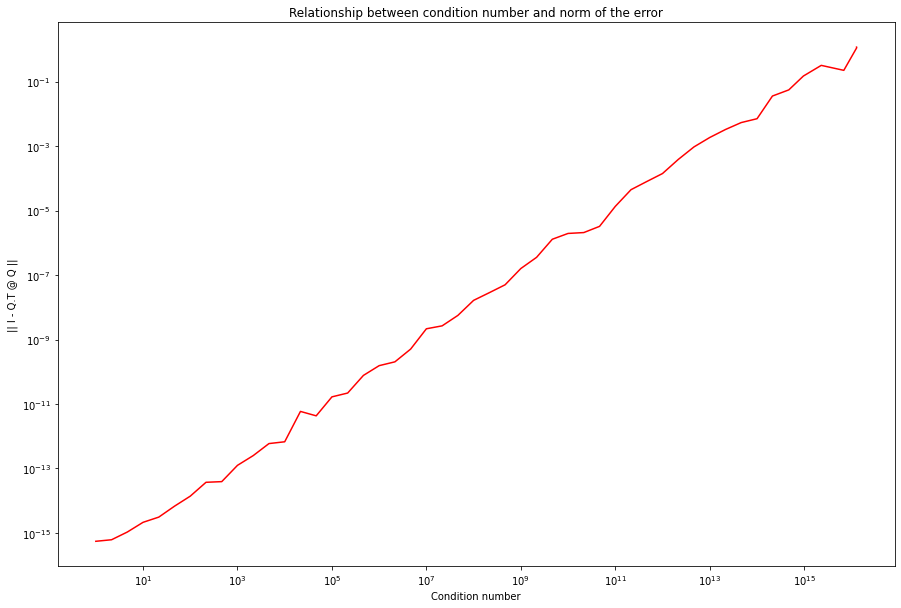

In [75]:
matrices = generate_matrices(50)

draw_cond_relationship(matrices)

### Solving overdetermined system

We are starting with the system:
$$Ax=b$$

Then we can make QR decomposition:
$$A=QR$$

And transform system to the form:
$$Rx=Q^T b$$

In [125]:
def solve_system(x, y):
    """ Solves overdetermined system of equations using QR decomposition
    
    :arg
        x: arguments of function which is being approximated
        y: values of that funtion
        
    return:
        coefficients of the result approximation funtion
            
    note:
            |1 x1 x1^2|
            |1 x2 x2^2|
            |1 x3 x3^2|
        A = |    .    |, x is a vector of coefficients we want and b is vector of values y
            |    .    |
            |    .    |
            |1 xn xn^2|
    """
    a = np.empty((x.shape[0], 3))
    a[:, 0] = 1
    a[:, 1] = x
    a[:, 2] = x * x
    
    q, r = qr(a)
    
    b = y.reshape(-1, 1)
    
    return solve(r, q.T @ b)


def draw_approximation(x, y):
    """ Draws points and approximation function 
    
    :arg
        x: arguments of function which is being approximated
        y: values of that funtion
    """
    coefficients = solve_system(x, y)
    
    points_x = np.linspace(-8, 8, 100)
    points_y = coefficients[0] + coefficients[1] * points_x + coefficients[2] * (points_x ** 2)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,10))
    
    ax.set_title("Approximation")
    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.scatter(x, y, c="#FF0000")
    ax.plot(points_x, points_y, c="#00BB00")
    
    plt.show()

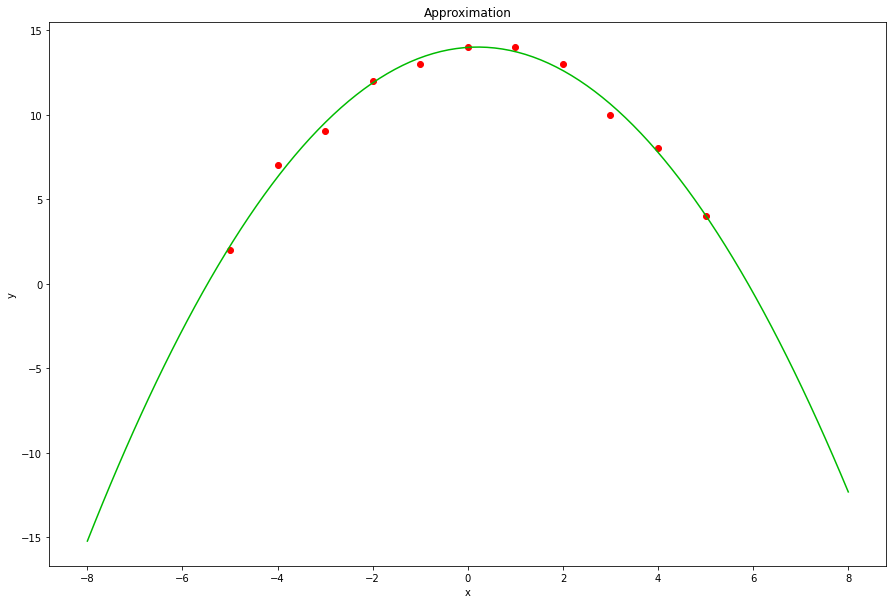

In [126]:
x = np.array([x for x in range(-5, 6)])
y = np.array([2, 7, 9, 12, 13, 14, 14, 13, 10, 8, 4])

draw_approximation(x, y)